In [1]:
import matplotlib.pylab as plt
import os

os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
import numpy as np
import pandas as pd

import networkx as nx
from networkx import Graph
from networkx.drawing.nx_pylab import draw
from networkx.algorithms.approximation import min_weighted_dominating_set
from networkx.algorithms.dominating import dominating_set

from dwave.system.samplers import DWaveSampler
from minorminer import find_embedding
from dwave.system.composites import EmbeddingComposite, FixedEmbeddingComposite
from dimod.utilities import qubo_to_ising
from dwave.embedding import embed_qubo

from qlp.mds import graph_tools as gt
from qlp.mds.qubo import get_mds_qubo
from qlp.mds.solver import classical_search
from qlp.mds.mds_qlpdb import (
    QUBO_to_Ising,
    retry_embedding,
    find_offset,
    AnnealOffset,
    plot_anneal_offset,
    graph_summary,
    experiment_summary,
    data_summary,
    insert_result,
)

In [2]:
nvertices = 5

{(2, 4), (1, 2), (0, 4), (2, 3), (0, 2), (1, 3)}
{(0, 1), (2, 4), (1, 2), (3, 4), (2, 3)}
isomorphic False


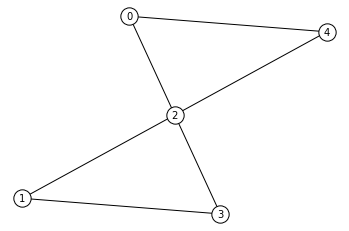

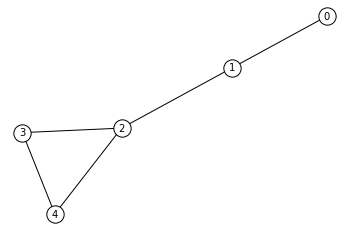

Greedy solution
 {0, 1}


In [3]:
#graph, tag = gt.generate_nn_graph(nvertices)
#graph, tag = gt.generate_corona_graph(2, 0)

graph, tag = gt.generate_erdos_renyi_graph(nvertices, np.log(nvertices)/nvertices)
print(graph)
from networkx.readwrite.edgelist import parse_edgelist
elist = [f"{i[0]} {i[1]}" for i in graph]
G = parse_edgelist(elist)

from networkx.algorithms.isomorphism import is_isomorphic
graph1, tag = gt.generate_erdos_renyi_graph(nvertices, np.log(nvertices)/nvertices)
print(graph1)
elist = [f"{i[0]} {i[1]}" for i in graph1]
G1 = parse_edgelist(elist)
print("isomorphic", is_isomorphic(G, G1))

# plot graph
gt.get_plot(graph, directed=False)
plt.show()
gt.get_plot(graph1, directed=False)
plt.show()

penalty = 2
qubo = get_mds_qubo(
    graph, directed=False, penalty=penalty, triangularize=True, dtype="d"
)

q_min = np.array(list(qubo.values())).min()

# greedy solution
G = nx.Graph()
G.add_edges_from(graph)
print("Greedy solution\n", dominating_set(G))

In [12]:
# Embedding retries
retries = 100000
# Set functional form of anneal offset
offtype = "binary"
target_min = 0.0
target_range = 0.0
problem_min = 0
problem_range = abs(problem_min)
# DWave parameters
annealing_time = 800  # integer microseconds [1, 2000] #OPTIMIZED
answer_mode = "raw"  # histogram or raw
auto_scale = True
num_reads = 1000  # raw will dump out all results
num_spin_reversal_transforms = 0 # OPTIMIZED
readout_thermalization = 0  # default 0
programming_thermalization = 1000  # default 1000

solver = "Advantage_system1.1"
sampler = DWaveSampler(solver=solver)

In [16]:
# convert to Ising
J, h, C = QUBO_to_Ising(qubo.todense().tolist())
maxJ = max(abs(J).flatten())
maxh = max(abs(h))
# Set chain strength
chain_strength = maxJ * 2

qubo_dict = {key: val for key, val in zip(qubo.keys(), qubo.values())}
qpu_graph = sampler.edgelist
embed, embedding, min_offset, max_offset = retry_embedding(
    sampler=sampler,
    qubo_dict=qubo_dict,
    qpu_graph=qpu_graph,
    graph_tag=tag,
    target_min=target_min,
    target_range=target_range,
    n_tries=retries,
    save=False
)

graph_params = graph_summary(tag, graph, qubo_dict)

# For anneal offsets
offsetcls = AnnealOffset(offtype, graph_params=graph_params)
qubo_graph = nx.Graph() 
qubo_graph.add_edges_from(sampler.edgelist)
embedded_qubo = embed_qubo(qubo_dict, embedding, qubo_graph, chain_strength)
hembed, Jembed, _ = qubo_to_ising(embedded_qubo)
graph_params = graph_summary(tag, graph, qubo_dict)
offsetcls = AnnealOffset(offtype, graph_params=graph_params)
anneal_offsets, exp_tag, _ = find_offset(
    h=hembed,
    fcn=offsetcls.fcn,
    embedding=embedding,
    offset_min=problem_min,
    offset_range=problem_range,
)

# Run Dwave
dwave_config = {
    "annealing_time": annealing_time,  # integer microseconds [1, 2000]
    "answer_mode": answer_mode,  # histogram or raw
    "auto_scale": auto_scale,
    "num_reads": num_reads,  # raw will dump out all results
    "num_spin_reversal_transforms": num_spin_reversal_transforms,
    "readout_thermalization": readout_thermalization,  # default 0
    "programming_thermalization": programming_thermalization,  # default 1000
    "chain_strength": chain_strength,
    "anneal_offsets": anneal_offsets
}

experiment_params = experiment_summary(
    machine=solver,
    settings=dwave_config,
    penalty=penalty,
    chain_strength=chain_strength,
    tag=exp_tag,
)

result = embed.sample_qubo(qubo_dict, **dwave_config)
raw = result.to_pandas_dataframe()

data_params = data_summary(raw, graph_params, experiment_params)
print(graph_params)
print(experiment_params)
print(len(data_params["constraint_satisfaction"]))

{'tag': 'G(5,0.32188758248682003)', 'total_vertices': 5, 'total_edges': 6, 'total_qubits': 16, 'max_edges': 4, 'adjacency': [[2, 4], [1, 2], [0, 4], [2, 3], [0, 2], [1, 3]], 'adjacency_hash': '5efbf4a713c2511458073c1825373534'}
{'machine': 'Advantage_system1.1', 'settings': {'annealing_time': 800, 'answer_mode': 'raw', 'auto_scale': True, 'num_reads': 1000, 'num_spin_reversal_transforms': 0, 'readout_thermalization': 0, 'programming_thermalization': 1000, 'chain_strength': 16.0}, 'p': 2, 'chain_strength': 16.0, 'tag': 'FixEmbedding_Binary_0_0_z0', 'settings_hash': '276dcede5436c139fe990a26acfbb16f'}
1000


In [14]:
raw.sort_values("energy", ascending=True)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,chain_break_fraction,energy,num_occurrences
545,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,-9.0,1
306,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,-9.0,1
410,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,-9.0,1
954,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0.0,-8.0,1
754,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0.0,-8.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465,1,1,1,0,1,0,1,0,0,0,0,1,0,1,0,0,0.0,8.0,1
388,1,1,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0.0,9.0,1
102,0,0,1,1,1,1,1,0,0,1,0,0,0,0,0,0,0.0,9.0,1
853,1,1,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0.0,13.0,1
